## Setup

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from utils.functions import get_files_info
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Import Libraries
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose  # to split the time series into components
import statsmodels.tsa.api as smt

In [49]:
def calculate_ndvi(red_band, nir_band):
    denominator = nir_band + red_band
    ndvi = np.where(
        denominator != 0,
        (nir_band - red_band) / denominator,
        0.0
    )
    return ndvi

def calculate_evi(red_band, nir_band, blue_band):
    evi = 2.5 * ( (nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1) )
    return evi

def vectorize_sentinel_ndvi_256(file_path, red_idx=3, nir_idx=7):
    with rasterio.open(file_path) as src:
        img = src.read() 

        red = img[red_idx].astype(np.float32)
        nir = img[nir_idx].astype(np.float32)
        blue = img[1].astype(np.float32)  # Assuming blue band index is 1

        evi = calculate_evi(red, nir, blue)    
        ndvi = calculate_ndvi(red, nir)
        X = ndvi.reshape(-1)                

    return X

def load_rgb_timestamp(path):
    with rasterio.open(path) as src:
        img = src.read() / 4000
        rgb = np.stack([img[3], img[2], img[1]], axis=-1)  
    return rgb



## Data

In [56]:
base_dir = "s2_ejura_2017_2020"
H = W = 256

def extract_date(fname):
    base = os.path.basename(fname)
    token = base.split("_")[0]

    # Try common formats
    try:
        return pd.to_datetime(token)
    except ValueError:
        return pd.to_datetime(token, format="%Y%m%d")


n_files, name_files = get_files_info(base_dir)

name_files = sorted(name_files)
full_paths = [os.path.join(base_dir, fname) for fname in name_files]

print(f"Total number of files: {len(full_paths)}")

ndvi_time_series = []

for file_path in full_paths:
    # returns flattened NDVI vector (256*256,)
    ndvi_vector = vectorize_sentinel_ndvi_256(file_path)
    ndvi_time_series.append(ndvi_vector)

ndvi_time_series = np.array(ndvi_time_series)

X = ndvi_time_series.T

dates = [extract_date(fname) for fname in name_files]

X = pd.DataFrame(X,columns=dates)

X = X.sort_index(axis=1)
X.columns.name = "date"
X.index.name = "pixel_id"
X


Total number of files: 193
Total number of files: 193


/tmp/ipykernel_677228/2129356209.py:11: RuntimeWarning: divide by zero encountered in divide
  evi = 2.5 * ( (nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1) )


date,2017-01-07,2017-01-27,2017-02-06,2017-02-16,2017-02-26,2017-03-08,2017-03-18,2017-03-28,2017-04-07,2017-04-17,...,2019-11-13,2019-11-18,2019-11-23,2019-11-28,2019-12-03,2019-12-08,2019-12-13,2019-12-18,2019-12-23,2019-12-28
pixel_id,,,,,,,,,,,,,,,,,,,,,
0,0.153687,0.158082,0.117231,0.050425,0.061438,0.127224,0.108131,0.159513,0.100970,0.157634,...,0.465380,0.467056,0.403675,0.296786,0.260267,0.215458,0.229085,0.220221,0.233530,0.184684
1,0.145731,0.154566,0.117432,0.065091,0.059471,0.124606,0.084507,0.157250,0.100392,0.159229,...,0.466782,0.455287,0.343284,0.292730,0.239635,0.198214,0.204150,0.212313,0.214193,0.181077
2,0.164914,0.165613,0.120334,0.071997,0.061331,0.134524,0.083386,0.176471,0.103789,0.173171,...,0.460455,0.460061,0.364355,0.307884,0.247108,0.220693,0.215971,0.216418,0.215666,0.179523
3,0.167740,0.172586,0.120608,0.067083,0.062926,0.129474,0.069649,0.182435,0.102237,0.165812,...,0.454311,0.452841,0.362024,0.299751,0.254851,0.234875,0.227390,0.220735,0.220939,0.181566
4,0.161795,0.148879,0.108938,0.061758,0.060805,0.113419,0.046253,0.144878,0.102888,0.162089,...,0.448029,0.527481,0.383802,0.365147,0.292950,0.256081,0.231892,0.263432,0.243521,0.192407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,0.148801,0.163206,0.148446,0.045843,0.070595,0.158750,0.046168,0.197762,0.103526,0.251613,...,0.197381,0.286226,0.248325,0.296109,0.140455,0.270194,0.051649,0.207486,0.189014,0.166110
65532,0.160464,0.195045,0.153013,0.045217,0.060382,0.218003,0.058355,0.189718,0.111864,0.261035,...,0.203509,0.294345,0.309530,0.282388,0.141931,0.247829,0.056861,0.194403,0.244552,0.160910
65533,0.101183,0.117397,0.098397,0.057478,0.060485,0.129848,0.033932,0.152041,0.108365,0.246469,...,0.241688,0.211666,0.200128,0.175721,0.148930,0.166870,0.054609,0.126150,0.130833,0.139220


Total number of files: 193
Found 193 matching images.


/tmp/ipykernel_677228/3300443874.py:43: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  plt.rcParams['toolbar'] = 'toolmanager'


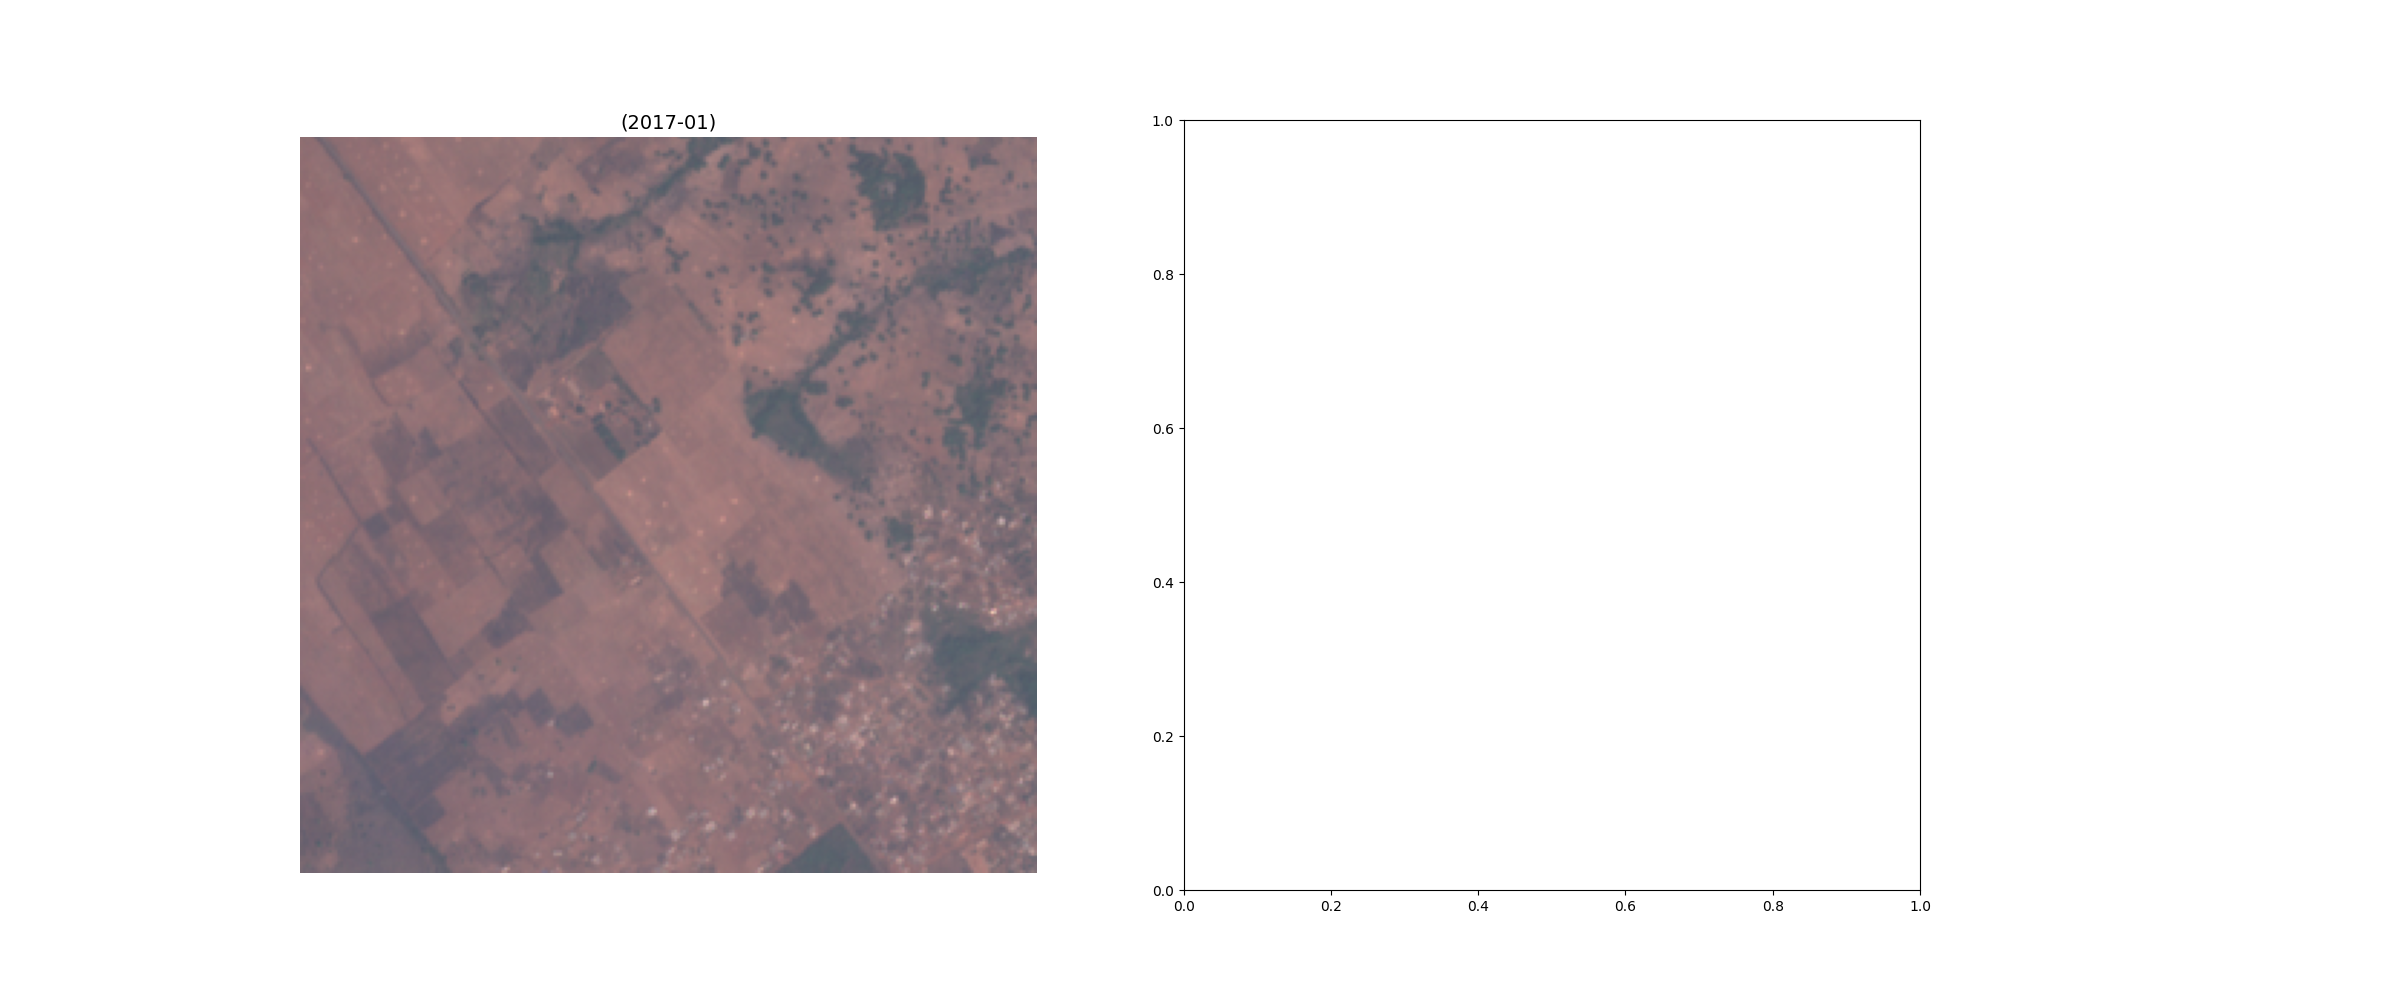

In [31]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import re
from datetime import datetime
import matplotlib.dates as mdates

scale = 3000
sample_point = "0"
# OUTDIR = "s2_ejura_2017_2018"
OUTDIR = "s2_ejura_2017_2020"

n_files, name_files = get_files_info(OUTDIR)
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

file_paths = []
dates = []
for f in matching_files:
    file_paths.append(os.path.join(OUTDIR, f))
    match = re.search(r"_(\d{8})T", f)
    if match:
        date_str = match.group(1)
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

n_image = 1
with rasterio.open(file_paths[n_image]) as src:
    img = src.read() / scale
img_rgb = np.clip(img[[3, 2, 1]].transpose(1, 2, 0), 0, 1)

fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(24, 10),
    gridspec_kw={'width_ratios': [1, 1]}
)
fig.subplots_adjust(right=0.8)
plt.rcParams['toolbar'] = 'toolmanager'

ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')})", fontsize=14)
ax_img.axis("off")

def plot_ndvi_time_series(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"NDVI Time-Series — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Date")
    ax_spec.set_ylabel("NDVI")
    ax_spec.grid(True, linestyle="--")
    
    ndvi_values = []
    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            img = src.read() / scale
        blue = img[1, y, x]  # banda 2 (BLUE)
        red = img[3, y, x]   # banda 4 (RED)
        nir = img[7, y, x]   # banda 8 (NIR)
        G, C1, C2, L = 2.5, 6.0, 7.5, 1.0
        denom = nir + C1 * red - C2 * blue + L
        evi = G * (nir - red) / (denom + 1e-6)

        # nir = img[7, y, x]   # banda 8 (NIR)
        # red = img[3, y, x]   # banda 4 (RED)
        # ndvi = (nir - red) / (nir + red + 1e-6)
        # ndvi_values.append(ndvi)

        ndvi_values.append(evi)
    
    valid_pairs = sorted(
        [(d, n) for d, n in zip(dates, ndvi_values) if d is not None],
        key=lambda x: x[0]
    )
    sorted_dates, sorted_ndvi = zip(*valid_pairs)
    
    # Plot da série temporal
    ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", label="NDVI", markersize=6)
    
    # Destacar o ponto n_image
    if dates[n_image] is not None:
        highlight_date = dates[n_image]
        highlight_ndvi = ndvi_values[n_image]
        ax_spec.plot(highlight_date, highlight_ndvi, "o", color="red", 
                    markersize=12, markeredgewidth=2, markeredgecolor='darkred',
                    label=f"Current Image ({highlight_date.strftime('%Y-%d-%m')})", zorder=5)
    
    # Formatar eixo X para mostrar apenas Ano-Mês
    ax_spec.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_spec.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax_spec.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Destacar pixel clicado na imagem RGB
    ax_img.clear()
    ax_img.imshow(img_rgb)
    ax_img.plot(x, y, 'r+', markersize=15, markeredgewidth=2)
    ax_img.plot(x, y, 'ro', markersize=20, markerfacecolor='none', 
               markeredgewidth=2, markeredgecolor='red')
    ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')}) - Pixel ({x}, {y})", fontsize=14)
    ax_img.axis("off")
    
    fig.canvas.draw_idle()

def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()

In [57]:
H = W = 256

row = 140
col = 125

pixel_idx = row * W + col

# pandas Series with dates as index
train = X.loc[pixel_idx]

train.index = pd.to_datetime(train.index)

train_2017 = train["2017"]
train_2018 = train["2018"]
train_2019 = train["2019"]
train_2017

date
2017-01-07    0.183420
2017-01-27    0.204110
2017-02-06    0.097653
2017-02-16    0.067779
2017-02-26    0.060541
2017-03-08    0.116618
2017-03-18    0.075008
2017-03-28    0.170829
2017-04-07    0.109112
2017-04-17    0.180467
2017-04-27    0.174838
2017-05-07    0.165289
2017-05-17    0.187168
2017-06-06    0.015138
2017-06-16    0.101555
2017-06-26    0.049513
2017-07-01    0.395067
2017-07-06    0.029360
2017-07-11    0.790378
2017-07-16    0.393172
2017-07-21    0.700870
2017-07-26    0.033510
2017-08-05   -0.013347
2017-08-15    0.465505
2017-08-20    0.029750
2017-08-25    0.040699
2017-08-30   -0.009711
2017-09-04    0.128937
2017-09-09    0.021258
2017-09-14    0.148014
2017-09-19    0.064505
2017-09-24    0.055202
2017-09-29    0.081118
2017-10-04    0.261021
2017-10-09    0.297937
2017-10-14    0.290948
2017-10-19    0.359122
2017-10-24    0.082560
2017-10-29    0.027152
2017-11-03    0.394086
2017-11-08    0.382660
2017-11-13    0.419579
2017-11-18    0.417609
2017-1

## Time-Series Smoothing

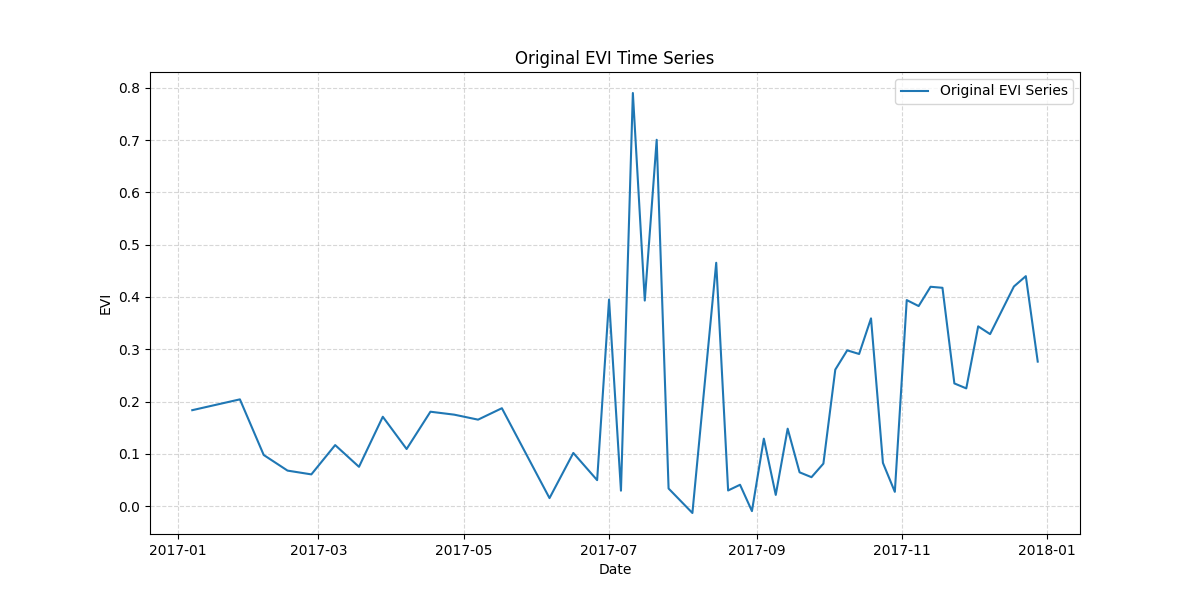

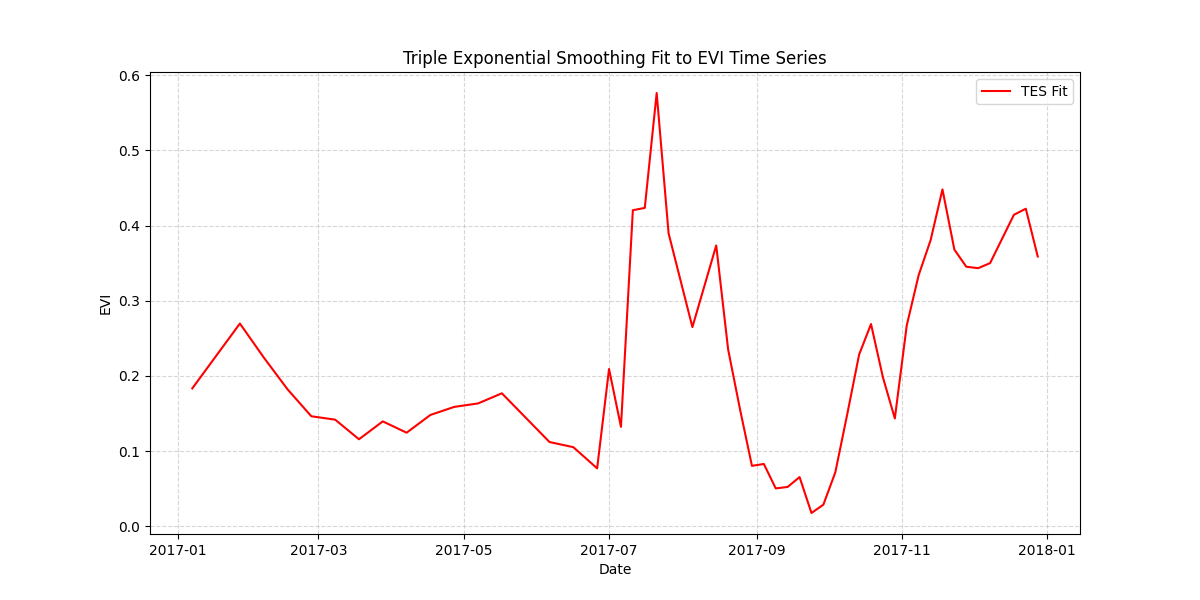

In [58]:
# Your custom TES function
def triple_exponential_smoothing(X, L, α, β, γ, ϕ):
    def sig_ϕ(ϕ, m):
        return np.sum(np.array([ϕ**i for i in range(m+1)]))

    C, S, B, F = (np.zeros(X.shape[0]) for _ in range(4))
    S[0], F[0] = X[0], X[0]
    B[0] = np.mean(X[L:2*L] - X[:L]) / L
    m = 12
    sig_phi = sig_ϕ(ϕ, m)

    for t in range(1, X.shape[0]):
        S[t] = α * (X[t] - C[t % L]) + (1 - α) * (S[t-1] + ϕ * B[t-1])
        B[t] = β * (S[t] - S[t-1]) + (1-β) * ϕ * B[t-1]
        C[t % L] = γ * (X[t] - S[t]) + (1 - γ) * C[t % L]
        F[t] = S[t] + sig_phi * B[t] + C[t % L]

    return F  # Return forecasted series

x = train_2017.values
L = 12  
α, β, γ, ϕ = 0.2, 0.1, 0.1, 0.9  # low values -> smoother series
fitted = triple_exponential_smoothing(x, L, α, β, γ, ϕ)

# Plot 1: Original series
plt.figure(figsize=(12, 6))
plt.plot(train_2017.index, x, label="Original EVI Series", color="C0")
plt.title("Original EVI Time Series")
plt.xlabel("Date")
plt.ylabel("EVI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Plot 2: TES fitted series
plt.figure(figsize=(12, 6))
plt.plot(train_2017.index, fitted, color='red', label="TES Fit")
plt.title("Triple Exponential Smoothing Fit to EVI Time Series")
plt.xlabel("Date")
plt.ylabel("EVI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


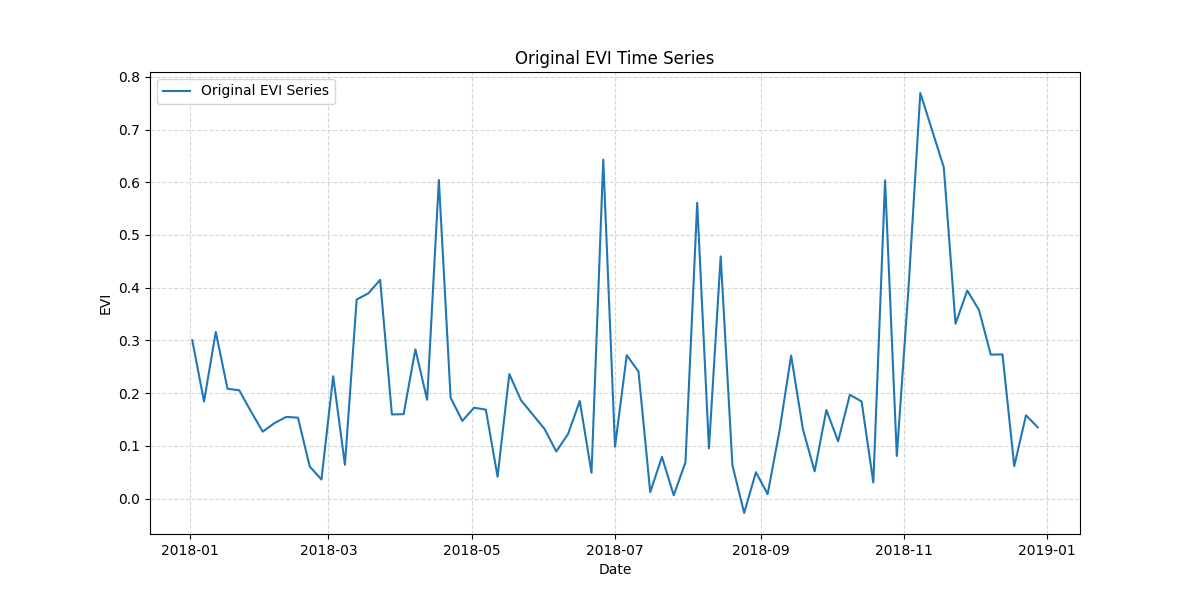

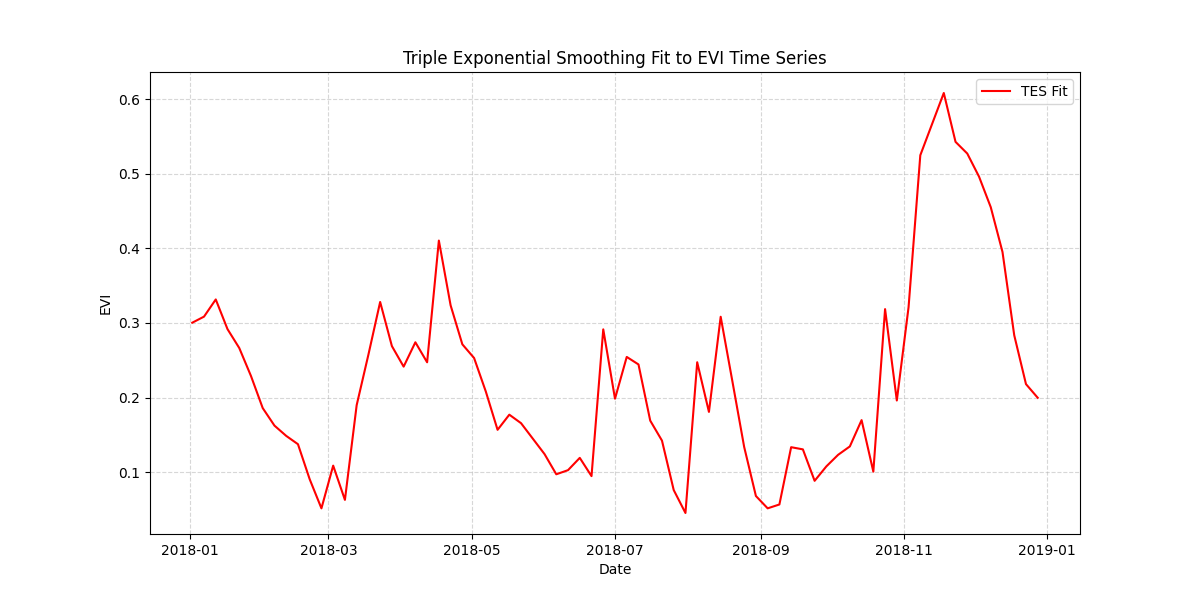

In [59]:
x = train_2018.values
L = 12  
α, β, γ, ϕ = 0.2, 0.1, 0.1, 0.9  # low values -> smoother series
fitted = triple_exponential_smoothing(x, L, α, β, γ, ϕ)

# Plot 1: Original series
plt.figure(figsize=(12, 6))
plt.plot(train_2018.index, x, label="Original EVI Series", color="C0")
plt.title("Original EVI Time Series")
plt.xlabel("Date")
plt.ylabel("EVI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Plot 2: TES fitted series
plt.figure(figsize=(12, 6))
plt.plot(train_2018.index, fitted, color='red', label="TES Fit")
plt.title("Triple Exponential Smoothing Fit to EVI Time Series")
plt.xlabel("Date")
plt.ylabel("EVI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


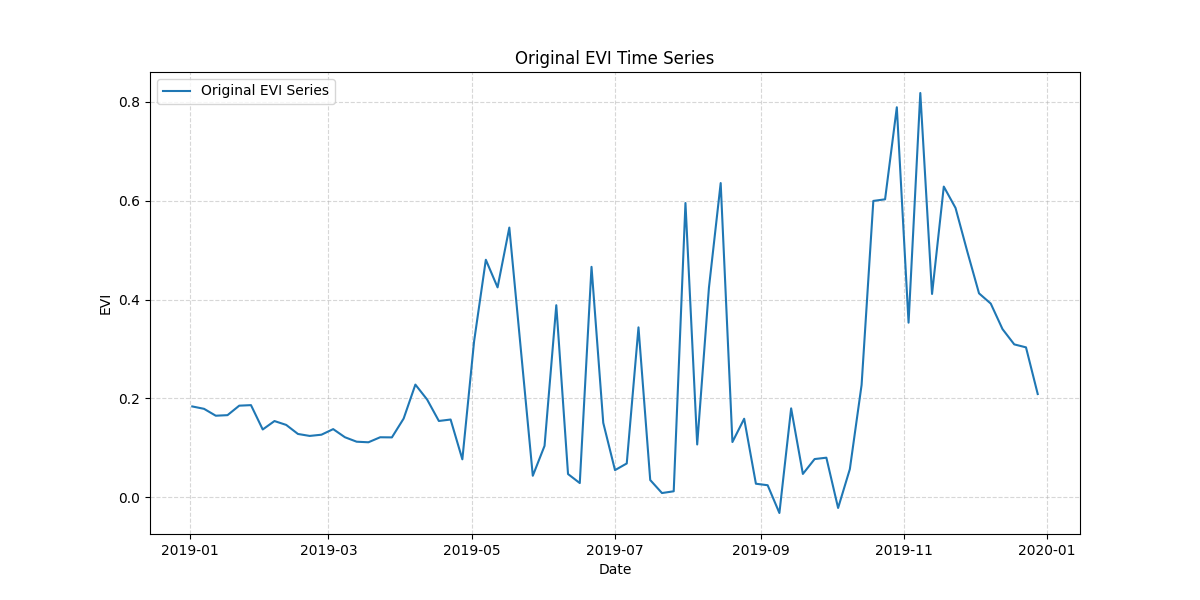

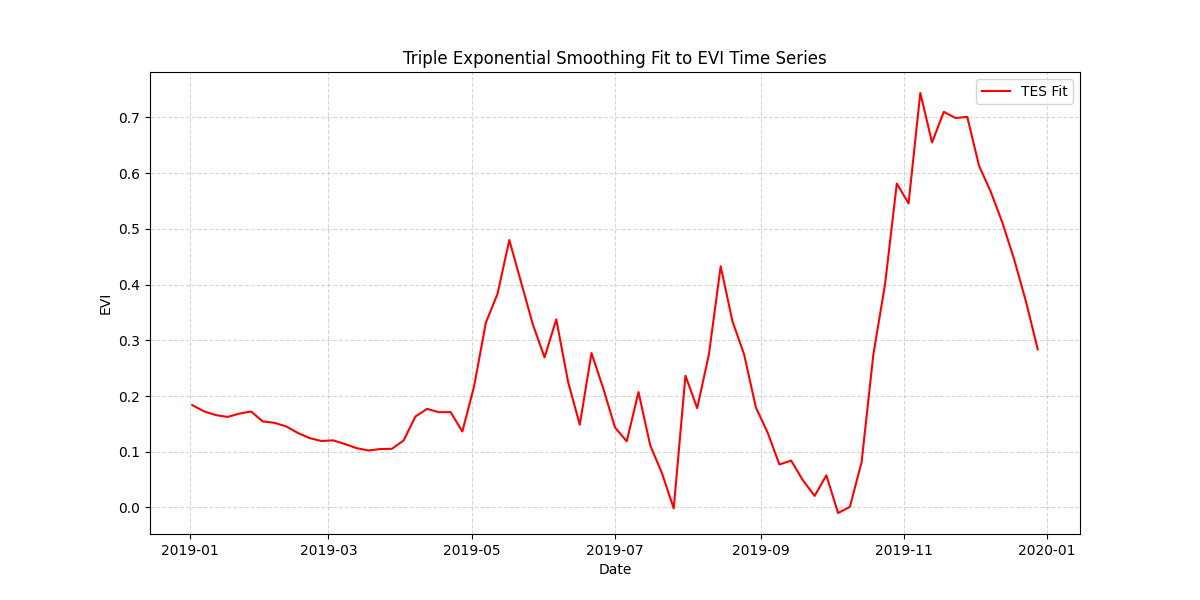

In [60]:
x = train_2019.values
L = 12  
α, β, γ, ϕ = 0.2, 0.1, 0.1, 0.9 
fitted = triple_exponential_smoothing(x, L, α, β, γ, ϕ)

# Plot 1: Original series
plt.figure(figsize=(12, 6))
plt.plot(train_2019.index, x, label="Original EVI Series", color="C0")
plt.title("Original EVI Time Series")
plt.xlabel("Date")
plt.ylabel("EVI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Plot 2: TES fitted series
plt.figure(figsize=(12, 6))
plt.plot(train_2019.index, fitted, color='red', label="TES Fit")
plt.title("Triple Exponential Smoothing Fit to EVI Time Series")
plt.xlabel("Date")
plt.ylabel("EVI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


## Model

In [61]:
# Normalize
scaler = StandardScaler()
timestamp = 10
X_norm = scaler.fit_transform(X[:, timestamp].reshape(-1, 1))
# X_norm = scaler.fit_transform(X)

# Clustering
K = 5
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_norm)

# Estimate Gaussian parameters for each cluster
mu = np.zeros((K, X.shape[1]))
sigma = np.zeros((K, X.shape[1]))
for c in range(K):
    cluster_data = X[cluster_labels == c]  
    mu[c] = np.mean(cluster_data, axis=0)
    sigma[c] = np.std(cluster_data, axis=0)


# Compute log-likelihood for each pixel
log_likelihood = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    c = cluster_labels[i]
    log_likelihood[i] = np.sum(norm.logpdf(X[i], mu[c], sigma[c]))


# Identify anomalies based on log-likelihood
epsilon = 1e-3
anomalies = log_likelihood < epsilon

InvalidIndexError: (slice(None, None, None), 10)

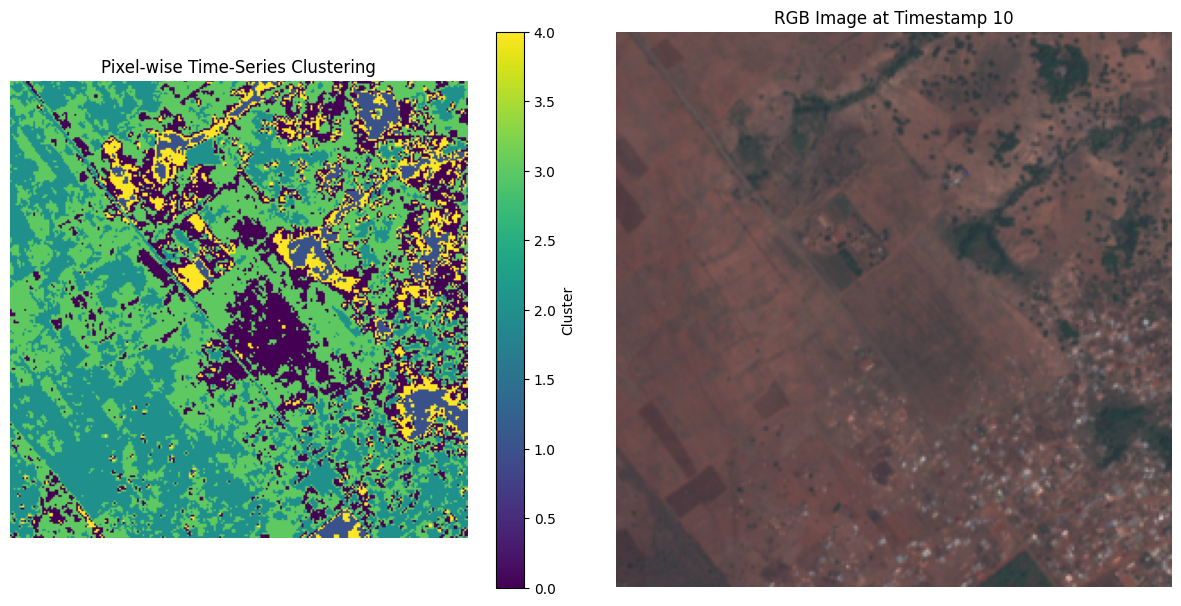

In [14]:
H = W = 256  
cluster_map = cluster_labels.reshape(H, W)
rgb = load_rgb_timestamp(os.path.join(base_dir, name_files[timestamp]))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cluster_map)
plt.title("Pixel-wise Time-Series Clustering")
plt.axis("off")
plt.colorbar(label="Cluster")

plt.subplot(1, 2, 2)
plt.imshow(rgb)
plt.title(f"RGB Image at Timestamp {timestamp}")
plt.axis("off")
plt.tight_layout()
plt.show()
